In [3]:
import numpy as np

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# ---------------------------
# Aggregation Layer
# ---------------------------
class AggregationLayer(layers.Layer):
    """
    Aggregates a set of features over the sequence dimension.
    Supported aggregations: "mean" or "max".
    """
    def __init__(self, aggreg="mean", **kwargs):
        super(AggregationLayer, self).__init__(**kwargs)
        self.aggreg = aggreg

    def call(self, inputs):
        if self.aggreg == "mean":
            return tf.reduce_mean(inputs, axis=1)
        elif self.aggreg == "max":
            return tf.reduce_max(inputs, axis=1)
        else:
            raise ValueError("Given aggregation string is not implemented. Use 'mean' or 'max'.")

# ---------------------------
# Linformer Multi-Head Attention
# ---------------------------
class LinformerMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, proj_dim, **kwargs):
        """
        Args:
          d_model: Dimensionality of the model.
          num_heads: Number of attention heads.
          proj_dim: The projection dimension to which keys and values will be reduced.
        """
        super(LinformerMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.proj_dim = proj_dim

    def build(self, input_shape):
        # input_shape: (batch_size, seq_len, d_model)
        self.seq_len = input_shape[1]
        # Standard dense weight matrices for Q, K, and V.
        self.wq = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wq")
        self.wk = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wk")
        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = layers.Dense(self.d_model)
        # Learnable projection matrices for keys and values.
        # These project along the sequence dimension from seq_len -> proj_dim.
        self.E = self.add_weight(shape=(self.num_heads, self.seq_len, self.proj_dim),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="proj_E")
        self.F = self.add_weight(shape=(self.num_heads, self.seq_len, self.proj_dim),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="proj_F")
        super(LinformerMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        # x shape: (batch_size, seq_len, d_model)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        # Transpose to shape: (batch_size, num_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Compute linear projections.
        q = tf.matmul(x, self.wq)  # (batch_size, seq_len, d_model)
        k = tf.matmul(x, self.wk)
        v = tf.matmul(x, self.wv)

        # Split into multiple heads.
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Project keys and values along the sequence dimension.
        # Using Einstein summation: for each head h,
        #   k_proj[b, h] = E[h]^T (applied on the sequence dim of k[b, h])
        # k_proj shape: (batch_size, num_heads, proj_dim, depth)
        k_proj = tf.einsum('bhnd, hnr -> bhrd', k, self.E)
        v_proj = tf.einsum('bhnd, hnr -> bhrd', v, self.F)

        # Scaled dot-product attention.
        # Compute scores between queries and projected keys.
        # scores shape: (batch_size, num_heads, seq_len, proj_dim)
        dk = tf.cast(self.depth, tf.float32)
        scores = tf.matmul(q, k_proj, transpose_b=True) / tf.math.sqrt(dk)
        attn_weights = tf.nn.softmax(scores, axis=-1)

        # Compute the attention output.
        # Output shape: (batch_size, num_heads, seq_len, depth)
        attn_output = tf.matmul(attn_weights, v_proj)

        # Concatenate heads.
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        concat_output = tf.reshape(attn_output, (batch_size, -1, self.d_model))
        output = self.dense(concat_output)
        return output

# ---------------------------
# Linformer Transformer Block
# ---------------------------
class LinformerTransformerBlock(layers.Layer):
    def __init__(self, d_model, d_ff, output_dim, num_heads, proj_dim, **kwargs):
        super(LinformerTransformerBlock, self).__init__(**kwargs)
        self.attention = LinformerMultiHeadAttention(d_model, num_heads, proj_dim)
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            layers.Dense(d_ff, activation='relu'),
            layers.Dense(d_model)
        ])
        self.outD = layers.Dense(output_dim)

    def call(self, x):
        attn_output = self.attention(x)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

# ---------------------------
# Linformer Transformer Classifier Model
# ---------------------------
def build_linformer_transformer_classifier(num_particles, feature_dim,
                                             d_model=16, d_ff=16, output_dim=16,
                                             num_heads=8, proj_dim=8):
    """
    Builds a classifier model with:
      - A linear embedding layer.
      - Multiple Linformer transformer blocks.
      - Aggregation over the sequence dimension.
      - A final linear output layer for 5 classes.
    """
    inputs = layers.Input(shape=(num_particles, feature_dim))
    
    x = layers.Dense(d_model, activation='relu')(inputs)
    
    x = LinformerTransformerBlock(d_model, d_ff, output_dim, num_heads, proj_dim)(x)    
    
    pooled_output = AggregationLayer(aggreg='max')(x)
    
    x = layers.Dense(d_model, activation='relu')(pooled_output)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)

# ---------------------------
# Example Training Setup
# ---------------------------
import numpy as np
from sklearn.model_selection import train_test_split




In [15]:
from sklearn.model_selection import train_test_split


In [16]:
import numpy as np

x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_150const_ptetaphi.npy")
y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_150const_ptetaphi.npy")

sort_indices = np.argsort(x_train[:, :, 0], axis=1)

x_train = np.take_along_axis(x_train, sort_indices[:, :, np.newaxis], axis=1)

# Perform an 80/20 split on the original training data
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)


In [17]:



# Determine input dimensions from data.
num_particles = x_train.shape[1]
feature_dim = x_train.shape[-1]

# Build and compile the Linformer transformer classifier.
model = build_linformer_transformer_classifier(num_particles, feature_dim,
                                               d_model=16, d_ff=16, output_dim=16,
                                               num_heads=4, proj_dim=4)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'linformer_transformer_block_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 150, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_2   │ (None, 150, 16)        │         6,448 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_2             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,869 (26.83 KB)

 Trainable params: 6,869 (26.83 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.load_weights

In [8]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=250, 
    batch_size=1024)

Epoch 1/250


2025-04-03 02:03:18.420840: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-03 02:03:18.436265: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


485/485 ━━━━━━━━━━━━━━━━━━━━ 54s 94ms/step - accuracy: 0.4138 - loss: 1.3611 - val_accuracy: 0.6638 - val_loss: 0.8960
Epoch 2/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.6746 - loss: 0.8700 - val_accuracy: 0.6939 - val_loss: 0.8281
Epoch 3/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.7096 - loss: 0.7957 - val_accuracy: 0.7261 - val_loss: 0.7657
Epoch 4/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.7282 - loss: 0.7538 - val_accuracy: 0.7330 - val_loss: 0.7396
Epoch 5/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.7438 - loss: 0.7210 - val_accuracy: 0.7553 - val_loss: 0.6983
Epoch 6/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.7561 - loss: 0.6942 - val_accuracy: 0.7618 - val_loss: 0.6806
Epoch 7/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.7639 - loss: 0.6759 - val_accuracy: 0.7643 - val_loss: 0.6735
Epoch 8/250
485/485 ━━━━━━━━━━━━━━━━━━━━ 39s 81ms/step - accuracy: 0.7670 - loss: 0.6674 - val_

In [10]:
model.save_weights('1layerLinformerCompressOne150partCompress4SortPt.weights.h5')

In [13]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph
import time
import numpy as np

def get_flops(model, input_shape):
    # Create a concrete function from the Keras model.
    input_tensor = tf.TensorSpec(input_shape, tf.float32)
    concrete_func = tf.function(model).get_concrete_function(input_tensor)
    
    # Convert the model to a frozen graph.
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    
    # Import the graph_def into a new graph.
    with tf.Graph().as_default() as graph:
        tf.compat.v1.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)
        return flops.total_float_ops

# Assuming x_val is already loaded and has shape (num_samples, features, ...)
# For a single event, we use a batch size of 1.
input_shape = [1] + list(x_val.shape[1:])
total_flops = get_flops(model, input_shape)
print("Total FLOPs for a single inference:", total_flops)

# ---------------------------
# Time Inference Per Event
# ---------------------------
# Warm-up: Run one inference to load any lazy initializations.
import numpy as np
import time

# Warm-up (optional but recommended)
_ = model(x_val[:10000])

num_trials = 100
inference_times = []
for _ in range(num_trials):
    start_time = time.perf_counter()
    _ = model(x_val[:10000])
    end_time = time.perf_counter()
    inference_times.append(end_time - start_time)

# Compute average inference time per event in seconds, then convert to nanoseconds
avg_inference_time_seconds = np.mean(np.array(inference_times) / 10000)
avg_inference_time_nanoseconds = avg_inference_time_seconds * 1e9

print("Average inference time per event:", np.round(avg_inference_time_nanoseconds,3), "nanoseconds")



2025-04-03 12:13:18.435922: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2025-04-03 12:13:18.435988: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-04-03 12:13:18.436184: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-03 12:13:18.436210: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Total FLOPs for a single inference:
=========================Options=============================
 587518
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation kernel type, such as MatMul, Conv2D. Graph nodes belonging to the same type are aggregated together.
flops: Number of float operations. 

In [17]:
x_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_val_robust_150const_ptetaphi.npy")
y_val = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_val_robust_150const_ptetaphi.npy")

In [2]:
sort_indices = np.argsort(x_val[:, :, 0], axis=1)

x_val = np.take_along_axis(x_val, sort_indices[:, :, np.newaxis], axis=1)

NameError: name 'np' is not defined

In [1]:
xout = np.argmax(model(x_val, training=False),1)
yout = np.argmax(y_val,1)

NameError: name 'np' is not defined

In [20]:
import sklearn
sklearn.metrics.accuracy_score(xout,yout)

0.8036576923076924

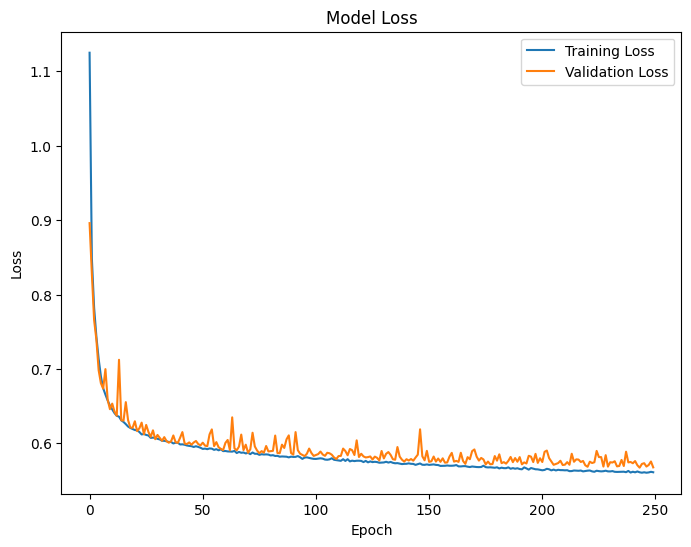

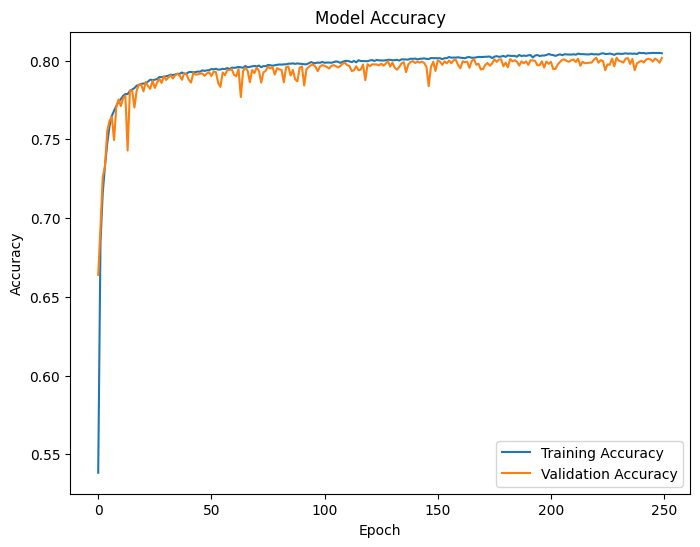

In [21]:
import matplotlib.pyplot as plt

# Suppose you have already trained your model:
# history = model.fit(...)

# Plotting the training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# If you also have accuracy or other metrics, you can plot them similarly:
if 'accuracy' in history.history:
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()


1/FPR at TPR=80% for each class:
g: 1/FPR = 12.861408834644694
q: 1/FPR = 9.329118432769368
W: 1/FPR = 46.5632003585836
Z: 1/FPR = 64.74501246882792
t: 1/FPR = 30.049985511445954
Average 1/FPR across classes: 32.70974512125431

Accuracy at the threshold corresponding to TPR=80% for each class:
g: accuracy = 0.8976
q: accuracy = 0.8748
W: accuracy = 0.9427
Z: accuracy = 0.9474
t: accuracy = 0.9330
Average accuracy across classes: 0.9191


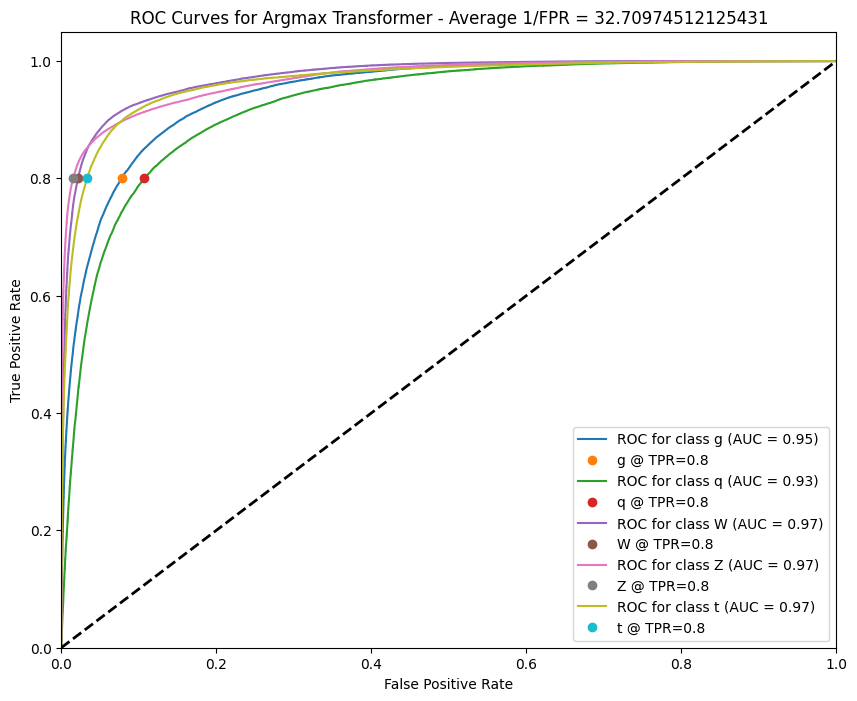

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import tensorflow as tf

# Define your class labels.
class_labels = ['g', 'q', 'W', 'Z', 't']

# Load your validation data.
# (Assuming x_val and y_val are already loaded in your environment)
# Get the model predictions as probabilities.
# If your model outputs logits, you may need to apply softmax first.
y_pred = model(x_val, training=False)

# Convert predictions and labels from TensorFlow tensors to NumPy arrays if needed.
if hasattr(y_pred, "numpy"):
    y_pred = y_pred.numpy()
if hasattr(y_val, "numpy"):
    y_val = y_val.numpy()

# Initialize dictionaries to store false positive rates, true positive rates, AUC, thresholds,
# interpolated FPR at target TPR, and accuracy at that threshold.
fpr = {}
tpr = {}
roc_auc = {}
thresholds_dict = {}
fpr_at_target = {}
accuracy_at_target = {}

# Target true positive rate.
target_tpr = 0.8

# Compute ROC curve, AUC, and interpolate FPR and threshold at target TPR for each class.
for i, label in enumerate(class_labels):
    # Compute ROC curve: returns fpr, tpr, and thresholds.
    fpr[i], tpr[i], thresholds = roc_curve(y_val[:, i], y_pred[:, i])
    thresholds_dict[i] = thresholds  # save thresholds for later use
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Check if the target TPR is reached.
    if target_tpr <= tpr[i][-1]:
        # Interpolate FPR at target TPR.
        fpr_at_target[label] = np.interp(target_tpr, tpr[i], fpr[i])
        # Interpolate threshold at target TPR.
        threshold_at_target = np.interp(target_tpr, tpr[i], thresholds)
        # Compute binary predictions for the current class using the interpolated threshold.
        preds_binary = (y_pred[:, i] >= threshold_at_target).astype(int)
        # Compute accuracy for the current class.
        accuracy = np.mean(preds_binary == y_val[:, i])
        accuracy_at_target[label] = accuracy
    else:
        fpr_at_target[label] = None  # If target TPR is not reached.
        accuracy_at_target[label] = None

# Display the 1/FPR values when TPR=80% for each class.
print("1/FPR at TPR=80% for each class:")
one_over_fpr = []
for label in class_labels:
    if fpr_at_target[label] is not None and fpr_at_target[label] != 0:
        inv_val = 1.0 / fpr_at_target[label]
        one_over_fpr.append(inv_val)
        print(f"{label}: 1/FPR = {inv_val}")
    else:
        print(f"{label}: undefined (FPR is None or zero)")

# Compute and print the average of 1/FPR across classes.
if one_over_fpr:
    avg_one_over_fpr = np.mean(one_over_fpr)
    print(f"Average 1/FPR across classes: {avg_one_over_fpr}")
else:
    print("No valid 1/FPR values to compute an average.")

# Print the accuracy at the FPR corresponding to TPR=80% for each class.
print("\nAccuracy at the threshold corresponding to TPR=80% for each class:")
accuracies = []
for label in class_labels:
    if accuracy_at_target[label] is not None:
        accuracies.append(accuracy_at_target[label])
        print(f"{label}: accuracy = {accuracy_at_target[label]:.4f}")
    else:
        print(f"{label}: accuracy undefined (target TPR not reached)")
if accuracies:
    avg_accuracy = np.mean(accuracies)
    print(f"Average accuracy across classes: {avg_accuracy:.4f}")
else:
    print("No valid accuracy values to compute an average.")

# Plot the ROC curves and mark the point corresponding to TPR=0.8.
plt.figure(figsize=(10, 8))
for i, label in enumerate(class_labels):
    plt.plot(fpr[i], tpr[i], label=f'ROC for class {label} (AUC = {roc_auc[i]:.2f})')
    if fpr_at_target[label] is not None:
        # Mark the point on the ROC curve where TPR = 0.8.
        plt.plot(fpr_at_target[label], target_tpr, 'o', label=f'{label} @ TPR=0.8')

# Plot the random chance line.
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Argmax Transformer - Average 1/FPR = ' + str(avg_one_over_fpr))
plt.legend(loc="lower right")
plt.show()



In [52]:
# Build the model with proj_dim = 1.
model = build_linformer_transformer_classifier(num_particles, feature_dim,
                                               d_model=16, d_ff=16, output_dim=16,
                                               num_heads=8, proj_dim=1)

# Compile the model (as before).
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Load the saved weights.
model.load_weights('1layerLinformerCompress1.weights.h5')

# Optionally, view the model summary.
model.summary()


/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'linformer_transformer_block_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 44 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ linformer_transformer_block_6   │ (None, 16, 16)         │         1,904 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_6             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325 (9.08 KB)

 Trainable params: 2,325 (9.08 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
class LinformerMultiHeadAttention(layers.Layer):
    def __init__(self, d_model, num_heads, proj_dim, **kwargs):
        super(LinformerMultiHeadAttention, self).__init__(**kwargs)
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads
        self.proj_dim = proj_dim
        # This will hold the attention weights from the last forward pass.
        self.last_attention_weights = None

    def build(self, input_shape):
        self.seq_len = input_shape[1]
        self.wq = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wq")
        self.wk = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wk")
        self.wv = self.add_weight(shape=(self.d_model, self.d_model),
                                  initializer='glorot_uniform',
                                  trainable=True,
                                  name="wv")
        self.dense = layers.Dense(self.d_model)
        self.E = self.add_weight(shape=(self.num_heads, self.seq_len, self.proj_dim),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="proj_E")
        self.F = self.add_weight(shape=(self.num_heads, self.seq_len, self.proj_dim),
                                 initializer='glorot_uniform',
                                 trainable=True,
                                 name="proj_F")
        super(LinformerMultiHeadAttention, self).build(input_shape)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x):
        batch_size = tf.shape(x)[0]
        q = tf.matmul(x, self.wq)
        k = tf.matmul(x, self.wk)
        v = tf.matmul(x, self.wv)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        k_proj = tf.einsum('bhnd, hnr -> bhrd', k, self.E)
        v_proj = tf.einsum('bhnd, hnr -> bhrd', v, self.F)
        dk = tf.cast(self.depth, tf.float32)
        scores = tf.matmul(q, k_proj, transpose_b=True) / tf.math.sqrt(dk)
        attn_weights = tf.nn.softmax(scores, axis=-1)
        # Save the attention weights so they can be inspected later.
        self.last_attention_weights = attn_weights
        attn_output = tf.matmul(attn_weights, v_proj)
        attn_output = tf.transpose(attn_output, perm=[0, 2, 1, 3])
        concat_output = tf.reshape(attn_output, (batch_size, -1, self.d_model))
        output = self.dense(concat_output)
        return output


In [12]:
def build_linformer_transformer_classifier(num_particles, feature_dim,
                                             d_model=16, d_ff=16, output_dim=16,
                                             num_heads=8, proj_dim=8):
    inputs = layers.Input(shape=(num_particles, feature_dim))
    
    x = layers.Dense(d_model, activation='relu')(inputs)
    
    # Name the block for easy access later.
    x = LinformerTransformerBlock(d_model, d_ff, output_dim, num_heads, proj_dim, name="transformer_block")(x)    
    
    pooled_output = AggregationLayer(aggreg='max')(x)
    
    x = layers.Dense(d_model, activation='relu')(pooled_output)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    return Model(inputs=inputs, outputs=outputs)


In [13]:
# Load data (make sure the file paths are correct)
x_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/x_train_robust_16const_ptetaphi.npy")
y_train = np.load("/Users/anrunw/Downloads/l1-jet-id/data/jetid/processed/y_train_robust_16const_ptetaphi.npy")

# Optionally, perform an 80/20 split if needed.
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, shuffle=True
)

num_particles = x_train.shape[1]
feature_dim = x_train.shape[-1]

# Build and compile the model.
model = build_linformer_transformer_classifier(num_particles, feature_dim,
                                               d_model=16, d_ff=16, output_dim=16,
                                               num_heads=8, proj_dim=1)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

# Take only one sample (one row) from the training data.
sample = x_train[:1]  # shape: (1, num_particles, feature_dim)

# Run a forward pass through the model.
_ = model(sample)

# Retrieve the attention weights.
# The transformer block is the third layer in the model (index 2).
# Its attention layer is accessible via its 'attention' attribute.
attention_matrix = model.get_layer("transformer_block").attention.last_attention_weights

# Print the attention matrix.
print("Attention Matrix shape:", attention_matrix.shape)
print("Attention Matrix values:\n", attention_matrix.numpy())


/Users/anrunw/miniconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/layer.py:395: UserWarning: `build()` was called on layer 'transformer_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 16, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 16, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 16, 16)         │         1,904 │
│ (LinformerTransformerBlock)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aggregation_layer_3             │ (None, 16)             │             0 │
│ (AggregationLayer)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,325 (9.08 KB)

 Trainable params: 2,325 (9.08 KB)

 Non-trainable params: 0 (0.00 B)

Attention Matrix shape: (1, 8, 16, 1)
Attention Matrix values:
 [[[[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]
   [1.]]

  [[1.]
   [1.]
   [1.]
  

In [71]:
np.zeros([16,16,4])[:,:,3]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [149]:
def superpositionMLP(superposition, weight, bias = np.zeros(16)):


    output = np.einsum('bij,ik->bkj', superposition, weight)

    output[:, :,3] += bias

    return output

def superPositionRelu(superposition):
    # Compute the sum of activations along each neuron's dimension.
    total_activations = np.sum(superposition, axis=2)
    
    # Zero out rows (neurons) with non-positive total activations.
    superposition[total_activations < 0] = 0
    return superposition

In [150]:
superposition = np.zeros((16, 3, 4))
num = 0
for x in x_val[0]:
    index = 0
    for feature in range(3):

        superposition[num, index, index] = x[index]

        index = index + 1
    num = num + 1

In [151]:
model.variables[1]

<Variable path=dense_28/bias, shape=(16,), dtype=float32, value=[-0.13730128 -0.17023899 -0.04812371 -0.06350124 -0.09528249 -0.13202193
  0.06482219  0.15857786  0.04920047  0.01534957  0.02712428  0.03955009
 -0.04367823 -0.03985824 -0.05933958 -0.18136433]>

In [152]:
superposition = superpositionMLP(superposition, model.variables[0], model.variables[1])
superposition = superPositionRelu(superposition)

In [153]:
superposition = superpositionMLP(superposition, model.variables[4])

In [160]:
superposition[0]

array([[ 6.78882964e-04,  3.54708613e-03, -1.87849032e-04,
        -2.72385209e-02],
       [-3.35905968e-03, -6.45207313e-03,  4.26786544e-03,
        -1.60015847e-02],
       [-9.08796234e-03, -1.64964727e-02, -2.78944434e-03,
         2.59307059e-02],
       [ 1.58776187e-03, -8.95994160e-05, -5.29249415e-03,
        -3.36708282e-02],
       [-7.04042084e-03,  5.41434104e-03, -3.92332908e-03,
        -1.12827108e-01],
       [-4.10277926e-03,  5.87353215e-03,  9.93852729e-05,
        -7.87967528e-02],
       [ 9.66920972e-04,  8.77597606e-04,  4.91945788e-03,
        -5.70989777e-02],
       [ 3.71548733e-03,  5.68443433e-03, -8.13824820e-04,
        -2.66003815e-02],
       [-4.36769056e-02, -4.09754564e-04,  3.38890568e-03,
        -3.14428142e-02],
       [ 1.75312202e-03,  1.23676898e-02, -1.92321974e-03,
         4.28216496e-02],
       [-2.11287729e-02,  1.40066084e-02,  5.19993333e-04,
         3.54282729e-03],
       [ 2.37767460e-03,  1.27788539e-03,  1.44062871e-03,
      

In [ ]:
import matplotlib.pyplot as plt

for num in range(8):
    plt.figure()
    # Get x values (0 to 127) and y values for the current row
    x = range(16)
    y = model.variables[6][num] 
    
    # Assign colors based on y value: red if below 0, blue if 0 or above
    colors = ['red' if val < 0 else 'blue' for val in y]
    
    # Create scatter plot with color coding
    plt.scatter(x, y, c=colors, s=10)
    plt.ylim(-1,1)
    # Draw a horizontal line at y = 0
    plt.axhline(y=0, color='black', linewidth=1)
    
    plt.show()
